In [1]:
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

%matplotlib inline

import shutil
import util.config as config
import subprocess

In [6]:
def get_imrmc_dir(name=config.output_directory + "/tmp/"):
    dirSave = name
    if os.path.exists(dirSave):
        shutil.rmtree(dirSave)
    os.makedirs(dirSave, exist_ok=True)
    return dirSave


dirSave = get_imrmc_dir()


def gen_imrmc_inputs(
    l_save_dict_name, output_dir, sensitivity=False, specificity=False, THRESHOLD=0.5
):
    allData = []
    for reader in l_save_dict_name:
        data = np.load(reader, allow_pickle=True)
        allData.append(data)

    for idm in range(len(allData[0])):
        lines = []

        lines.append("Simulated iMRMC input")
        lines.append("")
        lines.append("NR: {:d}".format(len(allData)))
        lines.append(
            "N0: {:d}".format(np.sum(np.array(allData[0][0]["true_labels"]) == 0))
        )
        lines.append(
            "N1: {:d}".format(np.sum(np.array(allData[0][0]["true_labels"]) == 1))
        )
        lines.append("NM: 1".format(len(allData[0])))
        lines.append("")
        lines.append("BEGIN DATA:")

        for idx, trial in enumerate(allData[0][0]["true_labels"]):
            lines.append("truth,TRIAL{:d},truth,{:d}".format(idx, int(trial)))

        for idx, reader in enumerate(allData):
            trials = allData[idx][idm]["prob_y0"]
            for t in range(len(trials)):
                if sensitivity:
                    if (
                        allData[idx][idm]["true_labels"][t] == 1.0
                        and trials[t] > THRESHOLD
                    ):  # disease case, correc
                        binary_decision = 1.0
                    elif (
                        allData[idx][idm]["true_labels"][t] == 1.0
                        and trials[t] <= THRESHOLD
                    ):
                        binary_decision = 0.0
                    else:
                        binary_decision = 0.5
                elif specificity:  # specificity
                    if allData[idx][idm]["true_labels"][t] == 1.0:
                        binary_decision = 0.5
                    elif (
                        allData[idx][idm]["true_labels"][t] == 0.0
                        and trials[t] > THRESHOLD
                    ):
                        binary_decision = 1.0
                    else:
                        binary_decision = 0.0
                else:
                    binary_decision = trials[t]

                lines.append(
                    "READER{:d},TRIAL{:d},DOSE{:011d},{:f}".format(
                        idx, t, int(allData[0][idm]["dose"]), binary_decision
                    )
                )
        with open(output_dir + "output.imrmc", "w") as outfile:
            outfile.write("\n".join(lines))


def getVals(dirSave):
    flList_imrmc = glob(dirSave + "*.imrmc")
    for flName in flList_imrmc:
        saveName = flName.replace(
            dirSave + "/output_", dirSave + "/processed_output_"
        ).replace(".imrmc", ".csv")
        out = subprocess.check_output(
            "Rscript imrmc/runMRMC.r " + flName + " " + saveName, shell=True
        )

    flList_imrmc_csv = glob(dirSave + "*.csv")
    l_val_AUCA = []
    l_val_varAUCA = []
    l_val_DOSE = []
    for i in range(len(flList_imrmc_csv)):
        csvName = flList_imrmc_csv[i]
        df = pd.read_csv(csvName)
        val_AUCA = df["AUCA"].iloc[0]
        val_varAUCA = df["varAUCA"].iloc[0]
        val_DOSE = float(df["modalityA"].iloc[0].replace("DOSE", ""))
        l_val_AUCA.append(val_AUCA)
        l_val_varAUCA.append(val_varAUCA)
        l_val_DOSE.append(val_DOSE)

    sort_indices = np.argsort(l_val_DOSE)
    l_val_DOSE = [l_val_DOSE[i] for i in sort_indices]
    l_val_varAUCA = [l_val_varAUCA[i] for i in sort_indices]
    l_val_AUCA = [l_val_AUCA[i] for i in sort_indices]
    l_val_stdAUCA = [np.sqrt(val) for val in l_val_varAUCA]
    return l_val_DOSE, l_val_varAUCA, l_val_AUCA, l_val_stdAUCA

In [7]:
# https://stackoverflow.com/questions/65013406/how-to-generate-30-distinct-colors-that-are-color-blind-friendly
colors = [
    "#E69F00",
    "#56B4E9",
    "#009E73",
    "#D55E00",
    "#CC79A7",
    "#004949",
    "#24ff24",
    "#920000",
    "#db6d00",
]

<h2>Plot Results

/tmp/ipykernel_258207/26929538.py:105: RuntimeWarning: invalid value encountered in sqrt
  l_val_stdAUCA = [np.sqrt(val) for val in l_val_varAUCA]


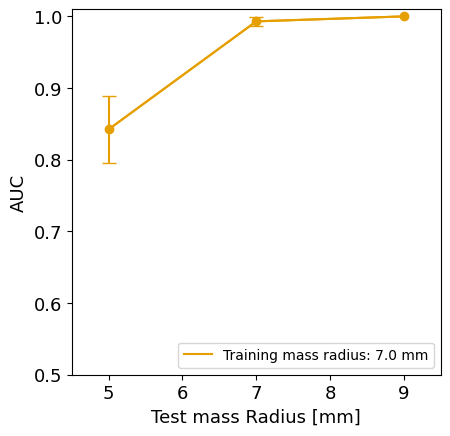

In [8]:
# Figure for impact of mass size (imrmc) -one figure
DENSITY = "fatty"
LESIONDENSITY = "1.06"
DETECTOR = "SIM"
DOSE = "2.22e10"

testDensity = "fatty"
testLesionDensity = "1.06"
testDose = "2.22e10"


NDICTS = 10
color_idx = 0
fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.3))
ax.set_xlabel("Test mass Radius [mm]", fontsize=13)
ax.set_ylabel("AUC", fontsize=13)
ax.set_ylim([0.5, 1.01])
ax.set_xlim([4.5, 9.5])
ax.tick_params(axis="both", labelsize=13)

l_trainSize = ["7.0"]
l_testSize = [5.0, 7.0, 9.0]
for trainSize in list(l_trainSize):
    l_val_AUCA_all = []
    l_val_stdAUCA_all = []
    for testsize in l_testSize:
        all_dict0 = []
        FLNAME = (
            "P2_" + str(testsize) + "_" + DETECTOR + "_" + testDose + "_" + testDensity
        )
        modelName = (
            "device_data_VICTREPhantoms_"
            + DENSITY
            + "_spic"
            + trainSize
            + "_id2_"
            + DETECTOR
            + "_"
            + LESIONDENSITY
            + "_"
            + DOSE
            + "_preprocessed1_basic_train_val_test"
        )
        all_dict00 = [
            name
            for name in glob(
                config.dir_training_data_preprocessed + modelName + "/dicts/all/*"
            )
        ]
        for dict_file in all_dict00:
            dictname = dict_file.split("/")[-1]
            out = dictname
            lesionDensity = float(dict_file.split("/")[-4].split("_")[7])
            if lesionDensity == float(testLesionDensity):
                all_dict0.append(dict_file)
        all_dict = [
            name
            for name in all_dict0
            if FLNAME in name and "FLOAT1" in name and "efficientnetb0" in name
        ]
        gen_imrmc_inputs(all_dict, dirSave)
        l_val_DOSE, l_val_varAUCA, l_val_AUCA, l_val_stdAUCA = getVals(dirSave)
        l_val_AUCA_all.append(l_val_AUCA[0])
        l_val_stdAUCA_all.append(l_val_stdAUCA[0])
    if trainSize == "ALLSIZES":
        try:
            ax.plot(
                l_testSize,
                l_val_AUCA_all,
                color=colors[color_idx],
                label="Training mass radius: All sizes",
            )
        except:
            continue
    else:
        ax.plot(
            l_testSize,
            l_val_AUCA_all,
            color=colors[color_idx],
            label="Training mass radius: " + trainSize + " mm",
        )
    ax.errorbar(
        l_testSize,
        l_val_AUCA_all,
        l_val_stdAUCA_all,
        fmt="-o",
        capsize=5,
        color=colors[color_idx],
    )
    color_idx += 1

plt.legend(loc="lower right", fancybox=True, shadow=False, ncol=1, fontsize=10)
plt.subplots_adjust(left=0.16, right=0.98, bottom=0.13, top=0.98, wspace=0.2)
plt.show()